In [16]:
import glob
import os
import pathlib
import shutil
import subprocess

import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None
NUM_WORKERS = os.cpu_count()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


def download_from_kaggle(expr, /, data_dir=None):
    """Download all files from the Kaggle competition/dataset.

    Args:
        expr: Match expression to be used by kaggle API, e.g.
            "kaggle competitions download -c competition" or
            "kaggle datasets download -d user/dataset".
        data_dir: Optional. Directory path where to save files. Default to `None`,
        which means that files will be downloaded to `data` directory.

    Notes:
        If the associated files already exists, then it does nothing.
    """

    if data_dir is None:
        data_dir = pathlib.Path("data/")
    else:
        data_dir = pathlib.Path(data_dir)

    match expr.split():
        case ["kaggle", _, "download", *args] if args:
            data_dir.mkdir(parents=True, exist_ok=True)
            filename = args[-1].split("/")[-1] + ".zip"
            if not (data_dir / filename).is_file():
                subprocess.run(expr)
                shutil.unpack_archive(filename, data_dir)
                shutil.move(filename, data_dir)
        case _:
            raise SyntaxError("Invalid expression!")

In [255]:
class MaxDepthPool2d(nn.Module):
    def __init__(self, pool_size=2):
        super().__init__()
        self.pool_size = pool_size

    def forward(self, x):
        shape = x.shape
        channels = shape[1] // self.pool_size
        new_shape = (shape[0], channels, self.pool_size, *shape[-2:])
        return torch.amax(x.view(new_shape), dim=2)


In [256]:
class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, squeeze_factor=16):
        super().__init__()
        squeeze_channels = in_channels // squeeze_factor
        self.feed_forward = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Flatten(),
            nn.Linear(in_channels, squeeze_channels),
            nn.ReLU(),
            nn.Linear(squeeze_channels, in_channels),
            nn.Sigmoid(),
        )

    def forward(self, x):
        calibration = self.feed_forward(x)
        return x * calibration.view(-1, x.shape[1], 1, 1)


In [257]:
class ResidualConnection(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, squeeze_active=False):
        super().__init__()
        pad = kernel_size // 2
        self.squeeze_active = squeeze_active
        self.squeeze_excitation = SqueezeExcitation(out_channels)
        self.feed_forward = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=pad, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.Mish(),
            nn.Conv2d(out_channels, out_channels, kernel_size, padding=pad, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.shortcut_connection = nn.Sequential()
        if not in_channels == out_channels or stride > 1:
            self.shortcut_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        x_residual = self.feed_forward(x)
        x_shortcut = self.shortcut_connection(x)
        residual_output = F.mish(x_residual + x_shortcut)

        if self.squeeze_active:
            return self.squeeze_excitation(residual_output) + x_shortcut

        return residual_output

In [8]:
x = torch.randint(0, 2, size=(32, 16, 224, 224), dtype=torch.float32).to(DEVICE)
res_con = ResidualConnection(16, 64, kernel_size=3, stride=2, squeeze_active=True).to(DEVICE)
res_con(x).shape


torch.Size([32, 64, 112, 112])

In [9]:
x = torch.randint(0, 2, size=(32, 16, 224, 224), dtype=torch.float32).to(DEVICE)
max_pool = MaxDepthPool2d()
max_pool(x).shape

torch.Size([32, 8, 224, 224])

In [226]:
cnn = nn.Sequential(
    #
    nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),
    nn.BatchNorm2d(64),
    nn.Mish(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(64),
    #
    ResidualConnection(64, 128, kernel_size=3, stride=2, squeeze_active=True),
    MaxDepthPool2d(pool_size=2),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.BatchNorm2d(num_features=64),
    #
    nn.Flatten(),
    #
    nn.Linear(64 * 14 * 14, 256, bias=False),
    nn.BatchNorm1d(256),
    nn.Mish(),
    nn.Dropout1d(0.4),
    #
    nn.Linear(256, 256, bias=False),
    nn.BatchNorm1d(256),
    nn.Mish(),
    nn.Dropout1d(0.4),
    #
    nn.Linear(256, 1),
).to(DEVICE)

In [11]:
x = torch.randint(0, 2, size=(32, 3, 224, 224), dtype=torch.float32).to(DEVICE)
cnn(x).shape

torch.Size([32, 1])

In [14]:
dataset = "tyre-quality-classification"
user = "warcoder"
expr = f"kaggle datasets download -d {user}/{dataset}"

if not ON_KAGGLE:
    download_from_kaggle(expr)
    dataset_path = pathlib.Path("data/tyres")
else:
    dataset_path = pathlib.Path(
        "/kaggle/input/tyre-quality-classification/"
        "Digital images of defective and good condition tyres"
    )

In [17]:
def get_train_valid_subsets(data_path, /, valid_ratio=0.2, seed=None):
    defective_paths = glob.glob(str(data_path / "defective/*"))
    good_paths = glob.glob(str(data_path / "good/*"))
    paths = np.concatenate((defective_paths, good_paths))

    defective_labels = [0] * len(defective_paths)
    good_labels = [1] * len(good_paths)
    labels = np.concatenate((defective_labels, good_labels))

    return train_test_split(
        paths, labels, test_size=valid_ratio, random_state=seed, stratify=labels
    )


train_paths, valid_paths, train_labels, valid_labels = get_train_valid_subsets(
    dataset_path, valid_ratio=0.125, seed=42
)

print("Training Image Paths:\n")
print(train_paths[:3])
print("\nTraining Labels:", train_labels[:3])

Training Image Paths:

['data\\tyres\\defective\\Defective (619).jpg'
 'data\\tyres\\good\\good (678).jpg'
 'data\\tyres\\defective\\Defective (411).jpg']

Training Labels: [0 1 0]


In [95]:
from PIL import Image
import time


class ImagePathsDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        if not len(paths) == len(labels):
            raise ValueError(f"'paths' length must be equal to 'labels' length")
        self.paths = paths
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        t0 = time.perf_counter()
        img = Image.open(self.paths[index])
        # print(time.perf_counter() - t0)
        label = self.labels[index]
        if self.transform is not None:
            transformed = self.transform(img)
            #print(time.perf_counter() - t0)
            return transformed, label
        #print(time.perf_counter() - t0)
        return img, label

In [260]:
transform = transforms.Compose(
    [
        transforms.Grayscale(3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.RandomVerticalFlip()
    ]
)

train_dataset = ImagePathsDataset(train_paths, train_labels, transform=None)
valid_dataset = ImagePathsDataset(valid_paths, valid_labels, transform=transform)

t0 = time.perf_counter()
img, label = train_dataset[0]
print(time.perf_counter() - t0)

0.0008353000011993572


0.03989200000069104


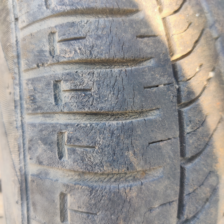

In [162]:
t0 = time.perf_counter()
img_resized = img.resize((224, 224), resample=Image.Resampling.BILINEAR)
print(time.perf_counter() - t0)
img_resized

In [183]:
tyres_dir = pathlib.Path("data/torch_data/")
tyres_dir.mkdir(parents=True, exist_ok=True)

defective_path = tyres_dir / "defective"
defective_path.mkdir(parents=True, exist_ok=True)

good_path = tyres_dir / "good"
good_path.mkdir(parents=True, exist_ok=True)

for k, (path, label) in enumerate(zip(train_paths, train_labels)):
    new_path = defective_path if label == 0 else good_path
    with Image.open(path) as image:
        img = image.resize((224, 224))
        img.convert(mode="RGB").save(new_path / f"{k}.jpg")

In [216]:
train_dataset = datasets.ImageFolder(tyres_dir, transform=transform)

t0 = time.perf_counter()
img, label = train_dataset[3]
print(time.perf_counter() - t0)

0.0020145000016782433


In [221]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# for batch, (X, y) in enumerate(train_loader):
#     print(batch)

In [252]:
import time


def clock(func):
    def clocked(*args, **kwargs):
        t0 = time.perf_counter()
        result = func(*args, **kwargs)
        t1 = time.perf_counter()
        name = func.__name__
        print(f"Epoch Time -> {t1 - t0:.5f}s", end=" ")
        return result

    return clocked

In [253]:
import collections

@clock
def train_step(model, dataloader, loss_fn, optimizer, device, scheduler):
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X).squeeze()
        loss = loss_fn(y_pred, y.float())
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        y_pred_class = torch.sigmoid(y_pred).round()#.type(torch.int32)
        #print(y_pred_class.round())
        #break
        train_acc += (y_pred_class == y).sum().item() / len(y)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc


def test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X).squeeze()
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = torch.sigmoid(test_pred_logits).type(torch.int32)
            test_acc += (test_pred_labels == y).sum().item() / len(y)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc


def train(model, train_dataloader, optimizer, loss_fn, epochs, device, scheduler):
    results = collections.defaultdict(list)

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device, scheduler)
        #test_loss, test_acc = test_step(model, train_dataloader, loss_fn, device)
        print(
            f"Epoch: {epoch} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            #f"test_loss: {test_loss:.4f} | "
           # f"test_acc: {test_acc:.4f}"
        )
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
       # results["test_loss"].append(test_loss)
       # results["test_acc"].append(test_acc)

    return results

In [254]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.NAdam(cnn.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2e-4, epochs=50, steps_per_epoch=50)

train(cnn , train_loader, optimizer, loss_fn, epochs=50, device=DEVICE, scheduler=scheduler)

Epoch Time -> 4.29958s Epoch: 1 | train_loss: 0.4739 | train_acc: 0.7096 | 
Epoch Time -> 3.97256s Epoch: 2 | train_loss: 0.4522 | train_acc: 0.7183 | 
Epoch Time -> 3.98174s Epoch: 3 | train_loss: 0.4582 | train_acc: 0.7057 | 
Epoch Time -> 3.79835s Epoch: 4 | train_loss: 0.4674 | train_acc: 0.6996 | 
Epoch Time -> 4.06667s Epoch: 5 | train_loss: 0.4499 | train_acc: 0.7157 | 
Epoch Time -> 3.60835s Epoch: 6 | train_loss: 0.4246 | train_acc: 0.7384 | 
Epoch Time -> 3.56083s Epoch: 7 | train_loss: 0.4545 | train_acc: 0.7145 | 
Epoch Time -> 3.54637s Epoch: 8 | train_loss: 0.4601 | train_acc: 0.7100 | 
Epoch Time -> 3.54365s Epoch: 9 | train_loss: 0.4630 | train_acc: 0.7075 | 
Epoch Time -> 4.26526s Epoch: 10 | train_loss: 0.4475 | train_acc: 0.7281 | 
Epoch Time -> 3.61896s Epoch: 11 | train_loss: 0.4693 | train_acc: 0.7002 | 
Epoch Time -> 3.97064s Epoch: 12 | train_loss: 0.4644 | train_acc: 0.7118 | 
Epoch Time -> 3.61755s Epoch: 13 | train_loss: 0.4628 | train_acc: 0.7030 | 
Epoch Ti

KeyboardInterrupt: 